Dataset Description and Location 

Human vs. LLM Text Corpus -  Roughly 800,000 pieces of text generated by either humans or LLMs

DOI: 10.34740/kaggle/dsv/7378735

Checking the folder location

In [5]:
import os
print(os.getcwd())

/home/vivek/code/nghia95/fake-data-detector/notebooks/text_text_final_model


Loading the Data and create a copy

In [6]:
import pandas as pd

# Define the updated file path
file_path = '/home/vivek/code/nghia95/fake-data-detector/data/10k_sampled_dataset.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

df_copy = df.copy()

Check if there is any empty data

In [7]:
print(df_copy.isnull().sum())

text           0
source         0
prompt_id      0
text_length    0
word_count     0
dtype: int64


Provide a glimpse of the data 

In [8]:
df_copy

,text,source,prompt_id,text_length,word_count
0,"In 1466, perhaps 40,000 people died of the pla...",Flan-T5-XXL,0,336,63
1,Amazon's yet-unnamed Lord of the Rings origina...,GLM-130B,0,2251,393
2,@Holt \n***Hi. I've just rewritten the essay....,Human,0,1994,337
3,Pleasantly surprised! Had a few options for ve...,GLM-130B,0,4182,797
4,Shakespeare’s Othello: A Tragic Hero Research ...,Human,0,12845,2143
...,...,...,...,...,...
9995,The Meaning of Civilization According to Willi...,Human,0,11346,1793
9996,Alicia was outside watering flowers. Alicia ac...,Flan-T5-XL,0,191,34
9997,Sandy was decided to take a hike in the mounta...,Flan-T5-Base,0,181,35
9998,Tommy wanted to buy a new computer. After some...,GPT-3.5,0,478,87


Installing the libraries necessary for the analysis 

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder
import joblib


Cleaning the Data

In [10]:
# Text cleaning function
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers (optional)
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

Applying the text cleaning function to the dataset

In [11]:
df_copy['cleaned_text'] = df_copy['text'].apply(clean_text)

Check the representative sample of the dataset for the analysis

In [12]:
# Get the sum of value counts for the 'source' column
total_counts = df_copy['source'].value_counts()

# Display the result
print(total_counts)

source
Human                       5577
GPT-3.5                     1488
Flan-T5-Base                 280
Flan-T5-Small                265
GLM-130B                     263
Bloom-7B                     257
Flan-T5-XXL                  254
GPT-4                        253
Flan-T5-Large                250
Flan-T5-XL                   236
GPT-J                        212
Claude-Instant-v1            205
GPT-NeoX                     174
Falcon-180B                  126
Claude-v1                     81
Gemini-Pro                    25
Goliath-120B                  20
Dolphin-Mixtral-8x7B          13
Cohere-Command                13
Dolphin-2.5-Mixtral-8x7B       8
Name: count, dtype: int64


Based on the source of the data, lets create two sources of data - AI and machine 

In [13]:
# Create a new column 'category' based on the 'source' column
df_copy['category'] = df_copy['source'].apply(lambda x: 'Human' if x == 'Human' else 'AI')

# Check the result
df_copy[['source', 'category']]

,source,category
0,Flan-T5-XXL,AI
1,GLM-130B,AI
2,Human,Human
3,GLM-130B,AI
4,Human,Human
...,...,...
9995,Human,Human
9996,Flan-T5-XL,AI
9997,Flan-T5-Base,AI
9998,GPT-3.5,AI


From the existing dataset, we take three features for this study, from this dataset

In [20]:
# Use 'text_length' and 'word_count' as additional features
X_text = df_copy['cleaned_text']
X_length = df_copy[['text_length', 'word_count']]  # These are numeric features

Split the data set and vectorise the text for TF_IDF

In [21]:
# Split dataset into train and test sets
y = df_copy['category']  # Assuming 'label' is your target column
X_train_text, X_test_text, X_train_length, X_test_length, y_train, y_test = train_test_split(X_text, X_length, y, test_size=0.2, random_state=42)

Lets vectorise the text, create TF_IDF and standardise the lenght and word_count

In [22]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=7000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# Scale the length features
scaler = StandardScaler()
X_train_length_scaled = scaler.fit_transform(X_train_length)
X_test_length_scaled = scaler.transform(X_test_length)

prepare a stack to upload the features

In [23]:
# Combine TF-IDF features with the scaled length features
X_train_combined = hstack([X_train_tfidf, X_train_length_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_length_scaled])

Convert y_train to numeric using LabelEncoder (as it is categorical)

In [47]:
label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y_train)
y_test_numeric = label_encoder.fit_transform(y_test)
y_test_numeric[2]

1

Model Building and Checking

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Create GradientBoostingClassifier model
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train_combined, y_train_numeric)

# Predict on the test set
y_pred_gb = model_gb.predict(X_test_combined)

# Evaluate the model
print(classification_report(y_test_numeric, y_pred_gb))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       884
           1       0.96      0.92      0.94      1116

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



Test and loss Graph

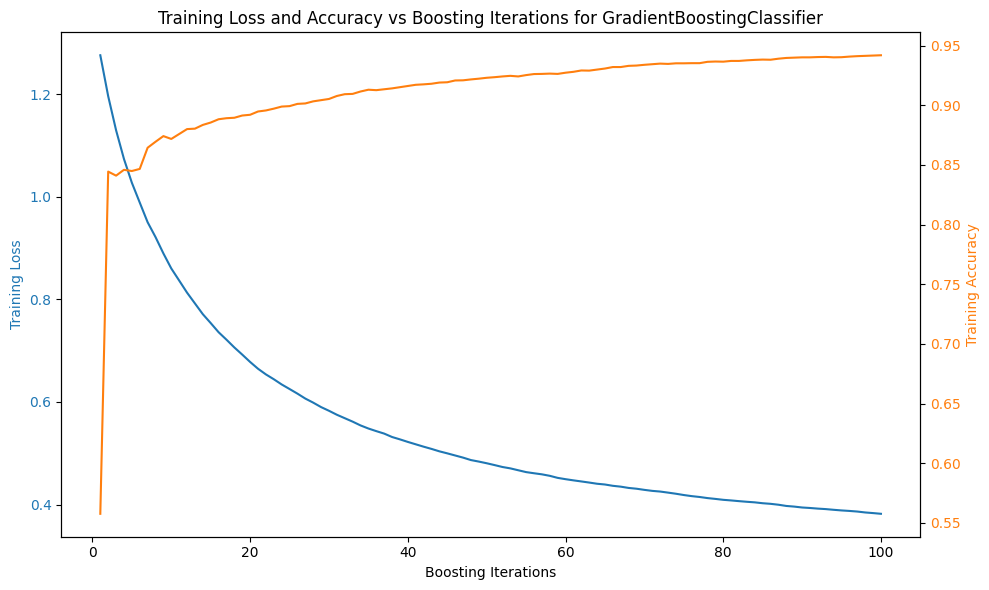

In [ ]:
# Track training loss and accuracy during each boosting iteration
train_losses = model_gb.train_score_  # Training loss for each iteration
train_accuracies = []  # To store accuracy at each stage

# Get predictions on the training set for each iteration
for i, y_pred_stage in enumerate(model_gb.staged_predict(X_train_combined)):
    accuracy = accuracy_score(y_train_numeric, y_pred_stage)  # Calculate accuracy at each stage
    train_accuracies.append(accuracy)

# Create the plot for training loss and accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting training loss
ax1.set_xlabel('Boosting Iterations')
ax1.set_ylabel('Training Loss', color='tab:blue')
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Creating a second y-axis to plot accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Training Accuracy', color='tab:orange')
ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and legends
plt.title('Training Loss and Accuracy vs Boosting Iterations for GradientBoostingClassifier')
fig.tight_layout()  # To ensure no overlap
plt.show()


Save the model 

In [52]:
# Create GradientBoostingClassifier model
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train_combined, y_train_numeric)

# Predict on the test set
y_pred_gb = model_gb.predict(X_test_combined)

# Evaluate the model
print(classification_report(y_test_numeric, y_pred_gb))

# Save the model using joblib
joblib.dump(model_gb, 'gradient_boosting_model.pb')


              precision    recall  f1-score   support

           0       0.90      0.95      0.92       884
           1       0.96      0.92      0.94      1116

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



['gradient_boosting_model.pb']

In [51]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Test text for prediction (the input you want to classify)
X_predicting_text = ["This is not AI, is it? Come on, I am a human being. You cannot call me AI. I am a human. See, I am typing. Can you?"]

# Compute additional features: text_length and word_count
text_length = [len(text) for text in X_predicting_text]  # Length of the text (number of characters)
word_count = [len(text.split()) for text in X_predicting_text]  # Word count in the text

# Use the same vectorizer that was used for training
# Assuming `vectorizer` is already fitted on the training data

# Transform the input text using the same vectorizer
X_predicting_tfidf = vectorizer.transform(X_predicting_text)

# Convert additional features (text_length and word_count) into a numpy array
additional_features = np.array([text_length, word_count]).T  # Transpose to match the shape

# Combine the TF-IDF features and the additional features
X_combined = np.hstack([X_predicting_tfidf.toarray(), additional_features])  # Combine TF-IDF and additional features

# Use the trained model to predict the category for the input text
predicted_category = model_gb.predict(X_combined)

# Convert the predicted numeric category (0 or 1) to a readable label (e.g., AI or Human)
predicted_label = "Human" if predicted_category[0] == 1 else "AI"

print(f"Predicted category for the test text: {predicted_label}")


Predicted category for the test text: Human
